**CLASSIFICATION**

Welcome dear reader. In this jupyter-notebook, you will meet the classification of nothing less but glass. Have you ever wondered about how a computer would classify your bedroom window? Wonder no more!

In [10]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot
import pandas as pd
from sklearn import model_selection
import torch
import time

font_size = 15
plt.rcParams.update({'font.size': font_size})

In [11]:
# loading data
filename = 'data/glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,1:10])
#       number of attributes
M = 9
#       type
y = np.array(df.iloc[:,10])

In [12]:
# the format of C needs to be this, so it is usable with torch, see before and after:
print(y)
y[y>3] = y[y>3] - 1
y = y - 1
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [39]:
# K = K_outer = K_inner
K = 10
CV_outer = model_selection.KFold(n_splits=K,shuffle=True)

#* INIT FOR LOGISTIC REGRESSION
# init for lambda-inner-loop
lambda_interval = np.logspace(-8, 2, 10)


#* INIT FOR STATISTICAL DATA
n_list = np.zeros(10)
mc_nemar = []
variance = np.zeros(10)


# init for error save
log_train_error = np.zeros(10)
log_test_error = np.zeros(10)

opt_lambda = np.zeros(10)
#coefficient_norm = np.zeros(len(lambda_interval))


#* INIT FOR BASE-LINE
base_line_train_err = np.zeros(10)
base_line_test_err = np.zeros(10)

#* INIT FOR ANN-CLASSIFICATION
max_iter = 10000
tolerance = 1e-6
logging_frequency = 1000
best_final_loss = 1e100
n_replicates = 1
ANN_error_test = np.zeros(K)
ANN_error_train = np.zeros(K)

h = [i for i in range(1,11)]

C = len(np.unique(y))

opt_h = np.zeros(10)


# init for time taking OPTIONAL

time_after_print = 0
time_elapsed = 0
#* OUTER LOOP
for m, (train_index, test_index) in enumerate(CV_outer.split(X,y)):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    n_list[m] = len(y_test)

    # TODO: CHECK IF THIS STANDARDIZATION IS CORRECT.
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis = 0)

    X_train = (X_train - mu)/sigma
    X_test = (X_test - mu)/sigma

    #init for optimal h
    h_error_train = np.zeros((K,len(h)))
    h_error_test = np.zeros((K,len(h)))

    #init for optimal lambda
    lambda_error_train = np.zeros((K,len(lambda_interval)))
    lambda_error_test = np.zeros((K,len(lambda_interval)))

    #* INNER LOOP
    ## ## GOAL: finding best lambda & finding best number of hidden neurons
    CV_inner = model_selection.KFold(n_splits=K,shuffle=True)
    for j, (train_index_inner, test_index_inner) in enumerate(CV_inner.split(X_train, y_train)):
        # printing
        
        time_before_print = time.time()
        time_difference = time_before_print - time_after_print
        if (j == 0) & (m == 0):
            time_difference = 0
        time_elapsed += time_difference
        
        print("outer_loop: " + str(m+1) + "/10. inner_loop: " + str(j+1) + "/10.  Time pr. iteration: " + str(round(time_difference)) + \
            " sec. Estimated time left: " + str(round((100*time_difference - time_elapsed)/60)) + str(" min."),end='\r')

        time_after_print = time.time()





        X_train_inner, X_test_inner = X_train[train_index_inner, :], X_train[test_index_inner, :]
        y_train_inner, y_test_inner = y_train[train_index_inner], y_train[test_index_inner]

        

        ##########################
        #* Finding the best lambda:
        # iterate over hyperparameter lambda
        for k in range(0, len(lambda_interval)):
            #'newton-cg' gives better results
            mdl = LogisticRegression(penalty='l2', solver='newton-cg', C=1/lambda_interval[k], max_iter=100)
            # but the other is faster but outputs hella lot of warnings:
            # mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k], max_iter=100)
            
            mdl.fit(X_train_inner, y_train_inner)

            y_train_est_inner = mdl.predict(X_train_inner).T
            y_test_est_inner = mdl.predict(X_test_inner).T
            
            lambda_error_train[j,k] = np.sum(y_train_est_inner != y_train_inner) / len(y_train_inner)
            lambda_error_test[j,k] = np.sum(y_test_est_inner != y_test_inner) / len(y_test_inner)

            # føler ikke det her skal bruges
            #w_est = mdl.coef_[0] 
            #coefficient_norm[k] = np.sqrt(np.sum(w_est**2))


        #* Finding the optimal amount of hidden layers:
        X_train_inner, X_test_inner = torch.tensor(X_train_inner, dtype=torch.float), torch.tensor(X_test_inner, dtype=torch.float)
        y_train_inner, y_test_inner = torch.tensor(y_train_inner), torch.tensor(y_test_inner)
        # reshaping helps torch
        #y_test_inner = torch.reshape(y_test_inner, (y_test_inner.shape[0],1))
        #y_train_inner = torch.reshape(y_train_inner, (y_train_inner.shape[0],1))


        # iterate over hyperparameter h
        for p, hidden_value_ in enumerate(h):
            # define the model for each hidden layer
            model_inner = lambda: torch.nn.Sequential(
                        torch.nn.Linear(M, hidden_value_), #M features to H hiden units
                        # 1st transfer function, either Tanh or ReLU:
                        #torch.nn.Tanh(),                            
                        torch.nn.ReLU(),
                        torch.nn.Linear(hidden_value_, C),
                        torch.nn.Softmax(dim=1)) #softmax as we want classes

            # loss function for multinomial classification
            loss_fn = torch.nn.CrossEntropyLoss()


            # Training the model
            for r in range(n_replicates):
                net_inner = model_inner()

                torch.nn.init.xavier_uniform_(net_inner[0].weight)
                torch.nn.init.xavier_uniform_(net_inner[2].weight)

                optimizer = torch.optim.Adam(net_inner.parameters())

                learning_curve = []
                old_loss = 1e6
                for i in range(max_iter):
                    y_est = net_inner(X_train_inner)
                    #y_class = torch.max(y_est, dim=1)[1]
                    loss = loss_fn(y_est, y_train_inner)
                    loss_value = loss.data.numpy()
                    learning_curve.append(loss_value)


                    p_delta_loss = np.abs(loss_value - old_loss)/old_loss
                    if p_delta_loss < tolerance: break
                    old_loss = loss_value


                    #if (i != 0) & ((i+1) % logging_frequency == 0):
                    #    print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                    #    print(print_str)
                    optimizer.zero_grad(); loss.backward(); optimizer.step()


            softmax_logits = net_inner(X_test_inner)
            y_test_est = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
            h_error_test[j, p]  = np.sum(y_test_est != np.array(y_test_inner))/len(y_test_inner)



    #* Optimal values found from inner loop
    #  the smallesst of the means of the differnet lambdas
    opt_lambda[m] = lambda_interval[np.argmin(np.mean(lambda_error_test,axis=0))]
    
    opt_h[m] = h[np.argmin(np.mean(h_error_test, axis = 0))]


    #* CLASSIFICATION
    ##########################
    ## BASELINE
    # find out which class has the highest count
    big_class = np.argmax([np.count_nonzero(y_train == i) for i in range(1,7)])
    # assign everything to this class (calculate error rate)
    base_line_train_err[m] = np.sum(y_train != big_class)/len(y_train)
    base_line_test_err[m] = np.sum(y_test != big_class)/len(y_test)


    ##########################
    ## Logistic Regression
    log = LogisticRegression(penalty='l2', C=1/opt_lambda[m], max_iter=1000)
    log.fit(X_train, y_train)
    y_train_est = log.predict(X_train)
    y_test_est_log = log.predict(X_test)

    log_train_error[m] = np.sum(y_train_est != y_train)/len(y_train)
    log_test_error[m] = np.sum(y_test_est_log != y_test)/len(y_test)

    ##########################
    ## ANN-Classification

    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, int(opt_h[m])), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]),int(opt_h[m])),
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]), C), # H hidden units to 1 output neuron
                    torch.nn.Softmax(dim=1) # final tranfer function
                    )


    X_train, y_train = torch.tensor(X_train, dtype = torch.float), torch.tensor(y_train)
    X_test, y_test = torch.tensor(X_test, dtype = torch.float), torch.tensor(y_test)
    n_replicates = 3
    for r in range(n_replicates):
        net = model()

        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)

        optimizer = torch.optim.Adam(net.parameters())

        learning_curve = []
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X_train)
            #y_class = torch.max(y_est, dim=1)[1]
            loss = loss_fn(y_est, y_train)
            loss_value = loss.data.numpy()
            learning_curve.append(loss_value)


            p_delta_loss = np.abs(loss_value - old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value


            # if (i != 0) & ((i+1) % logging_frequency == 0):
                #print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                ###print(print_str)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        

        #print('\t\tFinal Loss:')
        #print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        ##print(print_str)

        if loss_value < best_final_loss:
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        
    
    softmax_logits = net(X_test)
    y_test_est_ann = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
    ANN_error_test[m] = np.sum(y_test_est_ann != np.array(y_test))/len(y_test)

    ## STATISTICAL DATA
    ##MCNEMAR DATA
    data = np.array([y_test, y_test_est_ann, y_test_est_ann, (y_test == big_class)])
    mc_nemar.append(data)
    #nvm ; variance[m] = np.var(x_test)
    # (y_test)
    # (y_test_est_ann)
    # (y_test_est_log)
    # (y_test == big_class)

# WARNING: Inden du kligger på den flotte trekant.
# Det tager cirka 145 min

/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/nikolaj/opt/anaconda3/envs/AndSem/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
print("{:<15} | {:<15} {:<15} {:<15} {:<15} {:<15}".format('Outer fold i', 'h', 'E_ANN', 'lambda', 'E_log', 'E_base'))
print("-----------------------------------------------------------------------------------------")
for i in range(10):
    print("{:<15} | {:<15} {:<15.3f} {:<15.6f} {:<15.3f} {:<15.7f}".format(i+1, int(opt_h[i]), ANN_error_test[i], opt_lambda[i], log_test_error[i], base_line_test_err[i]))


Outer fold i    | h               E_ANN           lambda          E_log           E_base         
-----------------------------------------------------------------------------------------
1               | 9               0.455           0.599484        0.455           0.7272727      
2               | 9               0.318           0.046416        0.318           0.5454545      
3               | 7               0.227           0.599484        0.273           0.6363636      
4               | 10              0.318           0.046416        0.318           0.8181818      
5               | 10              0.238           0.599484        0.286           0.7142857      
6               | 8               0.381           0.046416        0.381           0.7142857      
7               | 8               0.381           0.046416        0.571           0.5714286      
8               | 9               0.381           0.003594        0.333           0.6666667      
9               | 10        

In [45]:
n_list

array([22., 22., 22., 22., 21., 21., 21., 21., 21., 21.])

In [43]:

import pandas as pd

table = np.array([n_list, opt_h, ANN_error_test, opt_lambda, log_test_error, base_line_test_err])

df = pd.DataFrame(np.transpose(table))

df.to_csv('classification_results.csv', index = False, header = ["test_size", "h", "ANN", "lambda", "Log", "Base"])



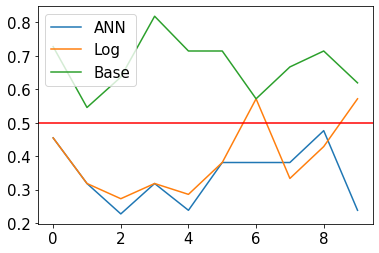

In [44]:
plt.plot(ANN_error_test)
plt.plot(log_test_error)
plt.plot(base_line_test_err)
plt.axhline(0.5,color='red')
plt.legend(['ANN', 'Log', 'Base'])